<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_Spring_2025/blob/master/08_01_PINN_HeatEqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Network (PINN) Example: Steady-State Heat Conduction

In this example, we implement a simple **Physics-Informed Neural Network (PINN)** to solve the one-dimensional steady-state heat conduction equation, which frequently arises in aerospace engineering contexts, such as thermal analysis of structural components or heat shielding.

## Governing Equation

The equation describing the temperature distribution $T(x)$ within a domain $x \in [0,1]$ under steady-state conditions with uniform heat generation $Q$ is given by:

$$
\frac{d^2T}{dx^2} + Q = 0,\quad 0\leq x\leq 1
$$

with the boundary conditions specified as:

$$
T(0) = T_0,\quad T(1) = T_1
$$

## Analytical Solution

The analytical solution to this problem is straightforward and is expressed as:

$$
T(x) = -\frac{Q}{2}x^2 + \left(T_1 - T_0 + \frac{Q}{2}\right)x + T_0
$$

## PINN Objective

In this notebook, we train a PINN to approximate the solution to this boundary value problem by minimizing a loss function that incorporates:

- **Physics-based loss** (to satisfy the differential equation)
- **Boundary-condition loss** (to enforce boundary conditions)

This example illustrates how PINNs integrate physical laws directly into neural network training, ensuring physically consistent solutions.


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set random seed
torch.manual_seed(42)


In [ ]:
# Problem parameters
T0, T1, Q = 0.0, 1.0, 1.0

# Analytical solution function
def analytical_solution(x):
    return -(Q / 2) * x**2 + (T1 - T0 + Q / 2) * x + T0


In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
def pinn_loss(model, x_colloc, x_bc, T_bc, Q):
    # Enable gradient computation w.r.t. inputs
    x_colloc.requires_grad = True

    # Predict T at collocation points
    T_pred = model(x_colloc)

    # Compute derivatives
    T_x = torch.autograd.grad(T_pred, x_colloc,
                              grad_outputs=torch.ones_like(T_pred),
                              create_graph=True)[0]

    T_xx = torch.autograd.grad(T_x, x_colloc,
                               grad_outputs=torch.ones_like(T_x),
                               create_graph=True)[0]

    # PDE residual
    f = T_xx + Q
    loss_pde = torch.mean(f**2)

    # Boundary condition loss
    T_bc_pred = model(x_bc)
    loss_bc = torch.mean((T_bc_pred - T_bc)**2)

    return loss_pde + loss_bc


In [ ]:
# Generate collocation points
x_colloc = torch.linspace(0, 1, 100).unsqueeze(-1)
x_bc = torch.tensor([[0.0], [1.0]])
T_bc = torch.tensor([[T0], [T1]])

# Initialize model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs+1):
    optimizer.zero_grad()
    loss = pinn_loss(model, x_colloc, x_bc, T_bc, Q)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.6f}')


Epoch: 0, Loss: 1.780057
Epoch: 500, Loss: 0.001710
Epoch: 1000, Loss: 0.000295
Epoch: 1500, Loss: 0.000213
Epoch: 2000, Loss: 0.000168
Epoch: 2500, Loss: 0.000128
Epoch: 3000, Loss: 0.000094
Epoch: 3500, Loss: 0.000067
Epoch: 4000, Loss: 0.000045
Epoch: 4500, Loss: 0.000027
Epoch: 5000, Loss: 0.000014


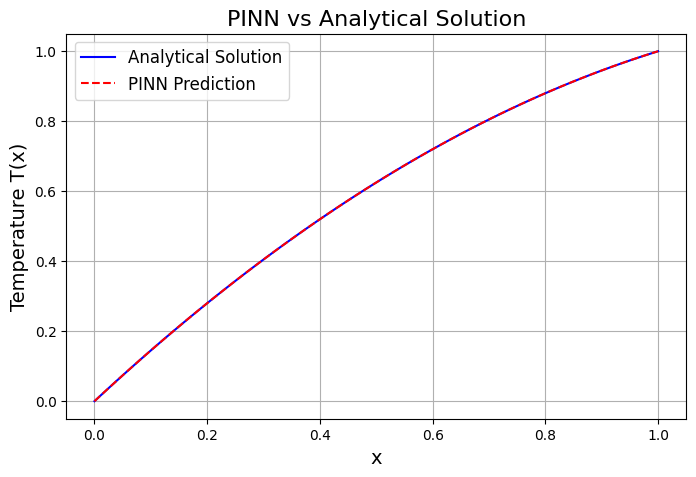

In [ ]:
# Prepare test data
x_test = torch.linspace(0, 1, 100).unsqueeze(-1)
T_pred = model(x_test).detach().numpy()
x_test_np = x_test.numpy().flatten()
T_exact = analytical_solution(x_test_np)

# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(x_test_np, T_exact, 'b-', label='Analytical Solution')
plt.plot(x_test_np, T_pred, 'r--', label='PINN Prediction')
plt.xlabel('x', fontsize=14)
plt.ylabel('Temperature T(x)', fontsize=14)
plt.title('PINN vs Analytical Solution', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
ErrorT = np.abs(T_exact - T_pred)/T_exact
# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(x_test_np, ErrorT, 'r-', label='Error')
plt.xlabel('x', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('PINN vs Analytical Solution', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

<ipython-input-17-d9c87aebb63e>:3: RuntimeWarning: divide by zero encountered in divide
  abs_percent_error = np.abs((T_exact - T_pred.flatten()) / (T_exact + epsilon)) * 100


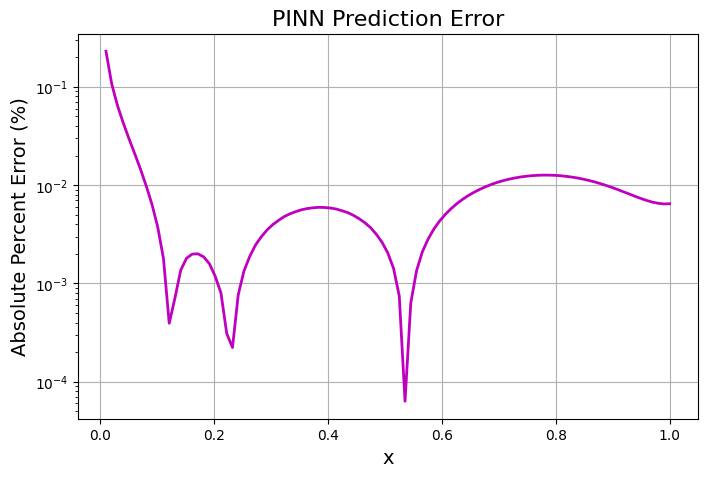

In [ ]:
# Compute absolute percent error
epsilon = 0.0# 1e-8  # Avoid division by zero
abs_percent_error = np.abs((T_exact - T_pred.flatten()) / (T_exact + epsilon)) * 100

# Plot absolute percent error
plt.figure(figsize=(8,5))
plt.semilogy(x_test_np, abs_percent_error, 'm-', linewidth=2)
plt.xlabel('x', fontsize=14)
plt.ylabel('Absolute Percent Error (%)', fontsize=14)
plt.title('PINN Prediction Error', fontsize=16)
plt.grid(True)
plt.show()
